[과제] bike_train.csv를 불어와서 다음 사항들을 고려하여 자전거 대여횟수를 예측하는 모델을 생성 후 평가하세요.

- datetime 타입에서 년, 월, 일, 시간 추출하여 반영 후 선형회귀 모델링 및 평가 
    - 사용자 함수 : RMSLE, RMSE, MAE
- 종속변수 정규성 개선위한 로그 변환
    - 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
    - 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할 
    - 선형회귀, ridge, lasso model 별로 평가 수행
    - 회귀계수 중요도 시각화


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

bike_df = pd.read_csv('./dataset/bike-sharing-demand/train.csv')
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [8]:
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

bike_df['year'] = bike_df.datetime.apply(lambda x:x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x:x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x:x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x:x.hour)
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [9]:
bike_df.drop(['datetime','casual','registered'],axis = 1,inplace=True)
bike_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    
    mae_val = mean_absolute_error(y,pred)
    
    print('rmsle',round(rmsle_val,4))
    print('rmse',round(rmse_val,4))
    print('mae',round(mae_val,4))

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
y = bike_df['count']
X = bike_df.drop('count',axis = 1)

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
pred = lr_reg.predict(X_test)
evaluate_regr(y_test,pred)

rmsle 1.1647
rmse 140.8996
mae 105.9244


In [16]:
def get_top_error(y_test,pred,n_tops = 5):
    result_df = pd.DataFrame(y_test.values,columns = ['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count']-result_df['predicted_count'])
    
    display(result_df.sort_values('diff',ascending=False)[:n_tops])
    
get_top_error(y_test,pred,n_tops=5)

,real_count,predicted_count,diff
1618,890,322.0,568.0
3151,798,241.0,557.0
966,884,327.0,557.0
412,745,194.0,551.0
2817,856,310.0,546.0


<AxesSubplot:>

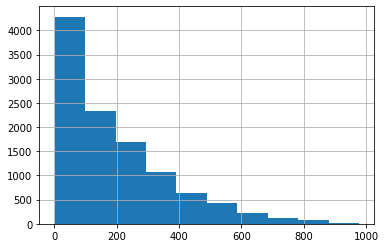

In [17]:
y.hist()

<AxesSubplot:>

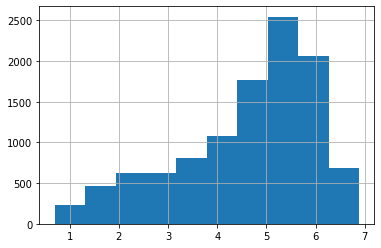

In [18]:
y_lt = np.log1p(y)
y_lt.hist()